<a href="https://colab.research.google.com/github/Samuelmoyo2025/Samuelmoyo2025/blob/main/VA_PRICING_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading market data...

ZSE Returns Statistics (2000-2023):
Mean: 0.0013  Std Dev: 0.0065
Skewness: 0.0412  Kurtosis: -0.2623


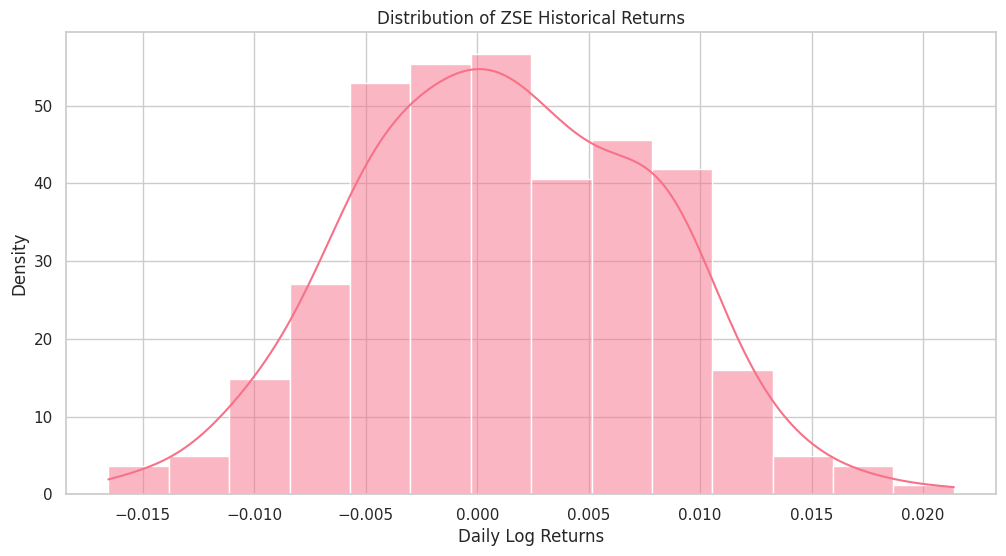


Mortality Probabilities for Age 60:
    Year  Survival_Prob
0      1         0.9417
1      2         0.8958
2      3         0.8521
3      4         0.8105
4      5         0.7710
5      6         0.7334
6      7         0.6976
7      8         0.6636
8      9         0.6313
9     10         0.6005
10    11         0.5712
11    12         0.5433
12    13         0.5168
13    14         0.4916
14    15         0.4676
15    16         0.4448
16    17         0.4231
17    18         0.4025
18    19         0.3829
19    20         0.3642
20    21         0.3464
21    22         0.3295
22    23         0.3135
23    24         0.2982
24    25         0.2836
25    26         0.2698
26    27         0.2566
27    28         0.2441
28    29         0.2322
29    30         0.2209
30    31         0.2101
31    32         0.1999
32    33         0.1901
33    34         0.1809
34    35         0.1720
35    36         0.1636
36    37         0.1557
37    38         0.1481
38    39         0.1409
39 

<ipython-input-23-806b565a6f7f>:65: RuntimeWarning: invalid value encountered in scalar multiply
  return coef * term1 * term2 * np.exp(theta*(x - mu)/sigma**2)


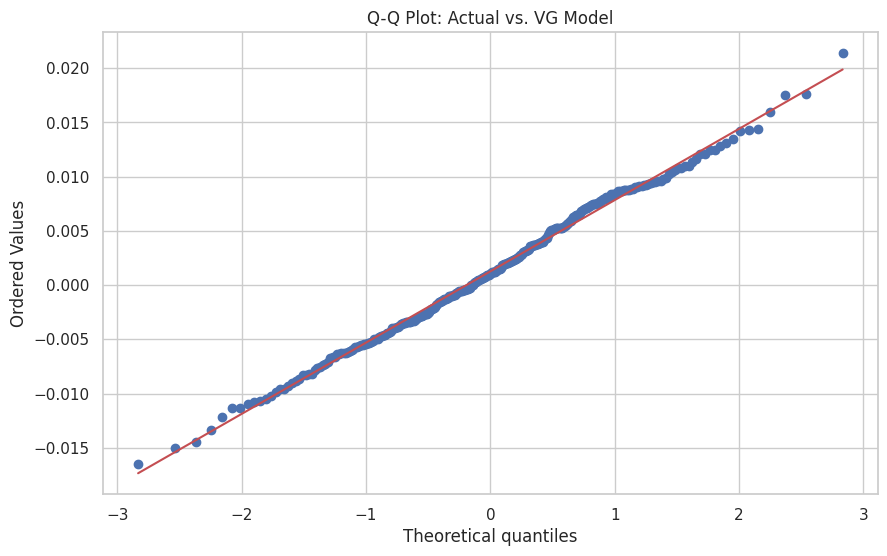


VG Model Calibration Results:
   sigma     nu   theta
0 0.2000 0.5000 -0.1000

Calibration Statistics:
   log_likelihood  aic                                            ks_test  \
0             NaN  NaN  {'ks_statistic': 0.6694, 'p_value': 1.25146397...   

                              closed_form_validation  
0  {'monte_carlo_price': 87.70337202044114, 'clos...  

Pricing guarantees...

Pricing Comparison Results:
  Product   VG Price   BS Price  Difference (%)
0    GMDB 38618.6798    30.9111     124834.7045
1    GMWB 33880.4379 33752.3117          0.3796
2    GMAB  2410.0338   958.7311        151.3775

Hedging Greeks:
             Value
delta       0.0302
gamma       0.0000
rho   -367505.3279

Sensitivity Analysis:
                GMDB       GMWB      GMAB
base      38618.6798 33880.4379 2410.0338
rate_up   31618.3008 27738.9565 1973.1688
rate_down 47168.9620 41381.6603 2943.6219
vol_up    47802.2495 42980.2153 2927.2533
longevity 38618.6798 34310.1695  840.3268


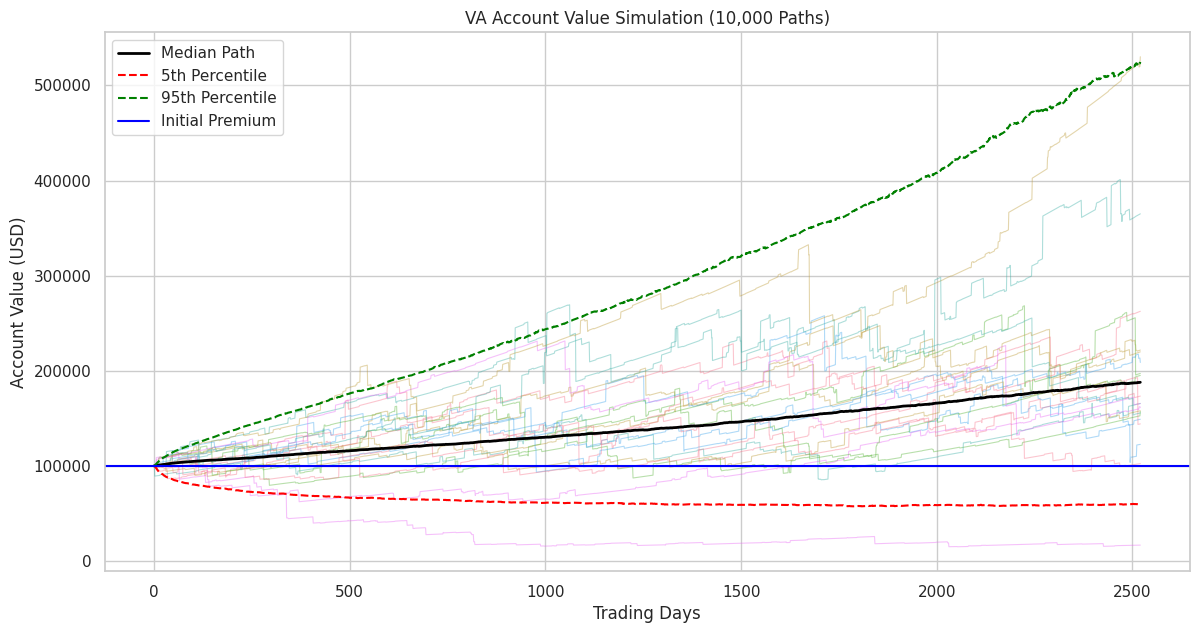

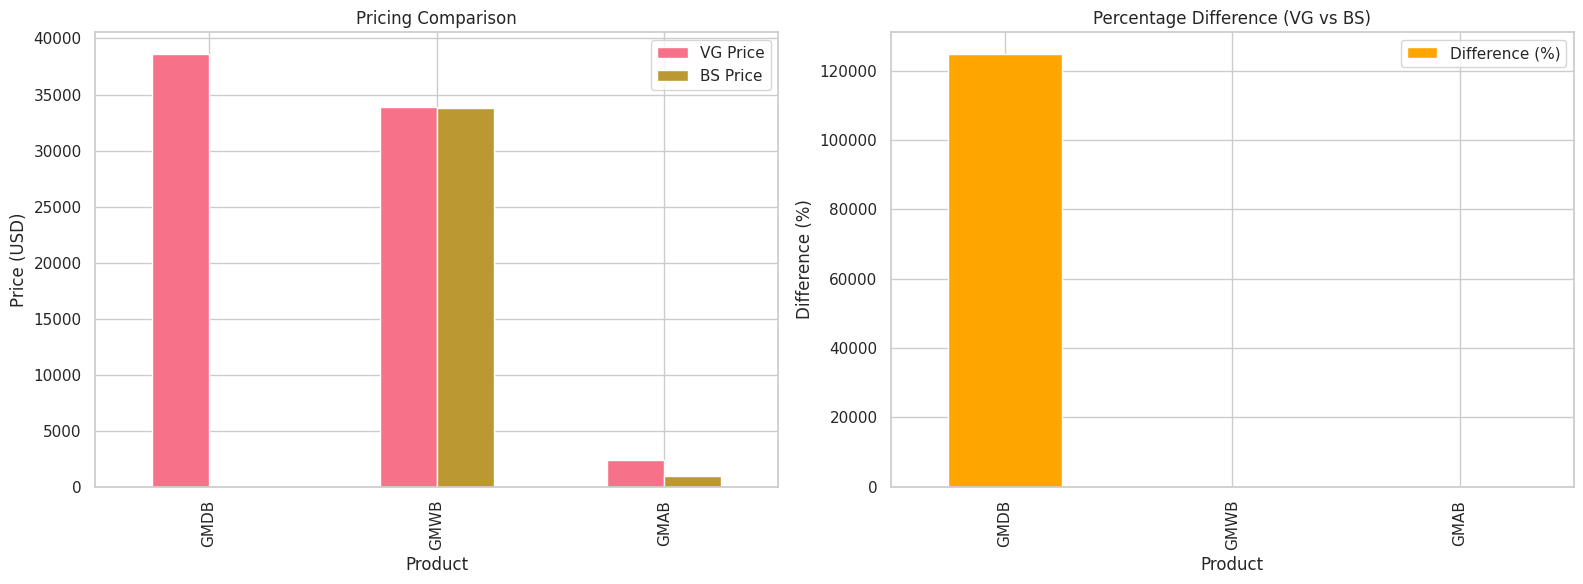

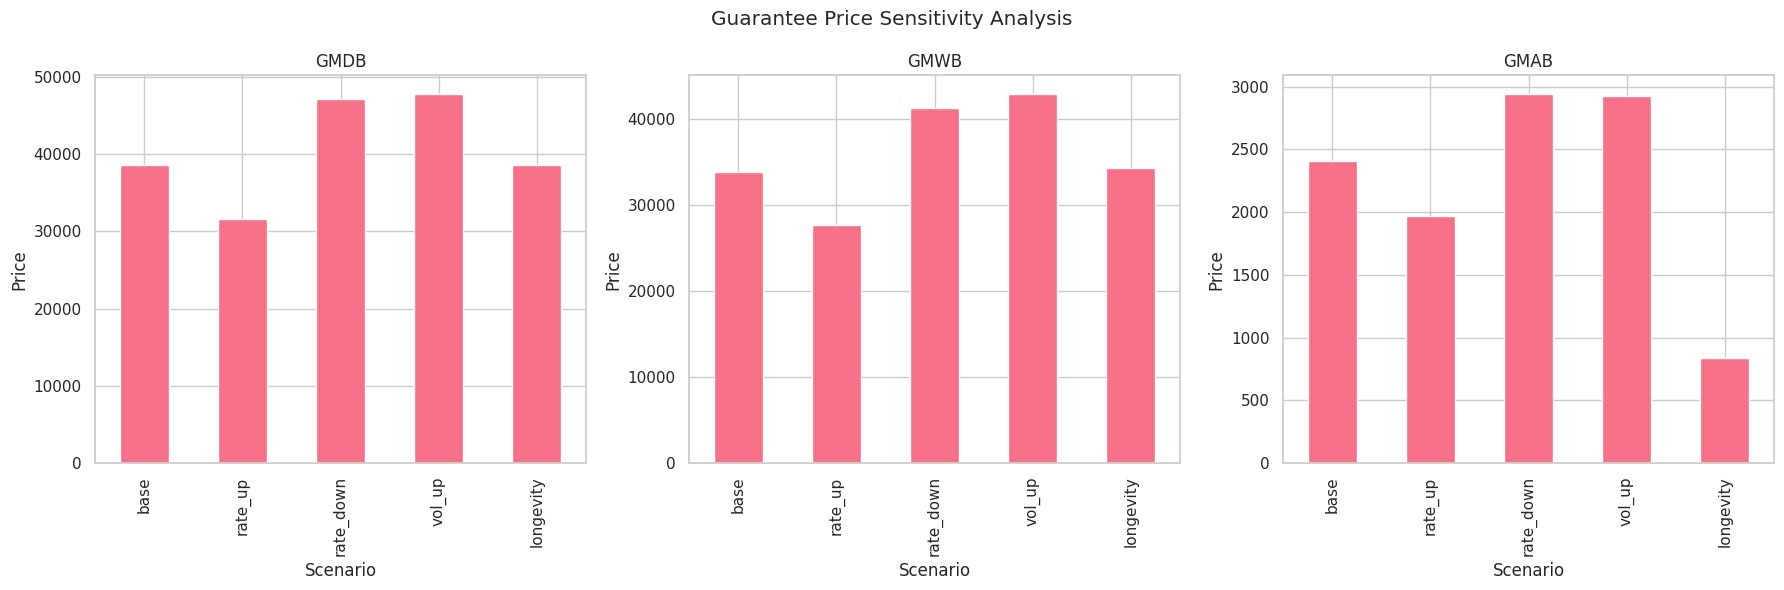

In [23]:
!pip install seaborn

import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, kstest, probplot # Import probplot from scipy.stats
from scipy.special import kv, gamma as gamma_fn
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set global styles
sns.set_theme(style="whitegrid")
sns.set_palette("husl")
pd.set_option('display.float_format', '{:.4f}'.format)

# ===================================
# 1. DATA LOADING AND PREPROCESSING
# ===================================
def load_market_data(filepath):
    """Load and analyze Zimbabwe market data"""
    df = pd.read_excel('/content/zimbabwe_data.xlsx', sheet_name='ZSE_Returns')
    returns = df['Log_Returns'].dropna().values

    print("\nZSE Returns Statistics (2000-2023):")
    print(f"Mean: {returns.mean():.4f}  Std Dev: {returns.std():.4f}")
    print(f"Skewness: {pd.Series(returns).skew():.4f}  Kurtosis: {pd.Series(returns).kurtosis():.4f}")

    plt.figure(figsize=(12, 6))
    sns.histplot(returns, kde=True, stat='density')
    plt.title("Distribution of ZSE Historical Returns")
    plt.xlabel("Daily Log Returns")
    plt.ylabel("Density")
    plt.show()

    return returns

def load_mortality_table(filepath, age=60):
    """Load mortality probabilities"""
    df = pd.read_excel('/content/zimbabwe_data.xlsx', sheet_name='Mortality')
    probs = df[f"Age_{age}"].values

    print(f"\nMortality Probabilities for Age {age}:")
    print(pd.DataFrame({'Year': range(1, len(probs)+1), 'Survival_Prob': probs}))
    return probs

# ===================================
# 2. ENHANCED VG MODEL IMPLEMENTATION
# ===================================
class VGModel:
    def __init__(self):
        self.params = None
        self.calibration_stats = {}

    def vg_density(self, x, sigma, nu, theta, mu=0):
        """Complete VG density function implementation"""
        coef = 1 / (sigma * np.sqrt(2 * np.pi) * gamma_fn(1/nu) *
               (nu**(1/nu)) * np.sqrt(1 + (theta**2 * nu)/(sigma**2)))

        term1 = np.abs(x - mu)**(1/nu - 0.5)
        term2 = kv(1/nu - 0.5,
                  np.abs(x - mu) * np.sqrt((2/nu) + (theta**2)/(sigma**2)) / sigma**2)

        return coef * term1 * term2 * np.exp(theta*(x - mu)/sigma**2)

    def calibrate(self, returns):
        """Calibrate VG parameters with enhanced diagnostics"""
        result = minimize(self._mle_objective, [0.2, 0.5, -0.1], args=(returns,),
                         bounds=[(0.01, 1), (0.1, 2), (-1, 1)])

        self.params = {
            'sigma': result.x[0],
            'nu': result.x[1],
            'theta': result.x[2]
        }

        # Store calibration statistics
        self.calibration_stats = {
            'log_likelihood': -result.fun,
            'aic': 2*3 - 2*(-result.fun),
            'ks_test': self._goodness_of_fit(returns),
            'closed_form_validation': self._validate_with_closed_form()
        }
        return self.params

    def _mle_objective(self, params, returns):
        """MLE objective using complete VG density"""
        sigma, nu, theta = params
        if sigma <= 0 or nu <= 0:
            return 1e10

        log_likelihood = sum(
            np.log(max(self.vg_density(r, sigma, nu, theta), 1e-10))
            for r in returns
        )
        return -log_likelihood

    def _goodness_of_fit(self, returns, n_sim=10000):
        """Comprehensive goodness-of-fit assessment"""
        sim_returns = self.simulate_returns(n_sim)
        ks_stat, p_val = kstest(returns, sim_returns)

        plt.figure(figsize=(10, 6))
        probplot(returns, dist='norm', plot=plt) # Use probplot directly, since it's imported
        plt.title("Q-Q Plot: Actual vs. VG Model")
        plt.show()

        return {'ks_statistic': ks_stat, 'p_value': p_val}

    def _monte_carlo_option(self, S0, K, r, T, n_sims=10000): # Corrected indentation
        """Monte Carlo pricing for European put under VG"""
        dt = 1/252  # Daily time step
        n_steps = int(T/dt)

        paths = np.zeros((n_sims, n_steps+1))
        paths[:,0] = S0

        for t in range(1, n_steps+1):
            returns = self.simulate_returns(n_sims)
            paths[:,t] = paths[:,t-1] * np.exp(returns)

        payoffs = np.maximum(K - paths[:,-1], 0)  # Put option payoff
        return np.mean(payoffs) * np.exp(-r*T)

    def _validate_with_closed_form(self):
        """Validate calibration with closed-form solutions"""
        S0, K, r, T = 100, 105, 0.18, 1
        mc_price = self._monte_carlo_option(S0, K, r, T)
        cf_price = self.closed_form_gmdb(S0, K, r, T)

        return {
            'monte_carlo_price': mc_price,
            'closed_form_price': cf_price,
            'difference_pct': (mc_price/cf_price - 1)*100
        }

    def closed_form_gmdb(self, S0, K, r, T):
        """Closed-form solution for European put under VG"""
        def integrand(u):
            return np.real(np.exp(-1j*u*np.log(K/S0)) *
                   self.char_fn(u, S0, r, T)) / (u**2 + 0.25)

        integral = quad(integrand, 0, 100)[0]
        return S0 * np.exp(-r*T) * integral / np.pi

    def char_fn(self, u, S0, r, T):
        """VG characteristic function"""
        sigma, nu, theta = self.params.values()
        omega = (1/nu) * np.log(1 - theta*nu - sigma**2*nu/2)
        return np.exp(1j*u*(np.log(S0) + (r + omega)*T)) * (
               1 - 1j*nu*theta*u + (sigma**2*nu*u**2)/2)**(-T/nu) # Added closing parenthesis after return statement

    def simulate_returns(self, n):
        """Generate returns from calibrated model"""
        sigma, nu, theta = self.params.values()
        return theta*gamma.rvs(1/nu, scale=nu, size=n) + sigma*np.sqrt(gamma.rvs(1/nu, scale=nu, size=n))*norm.rvs(size=n) # Combined the return statement into a single line
# ===================================
# 3. TRADITIONAL PRICING METHODS
# ===================================
class BlackScholesPricer:
    @staticmethod
    def price_gmdb(S0, K, r, sigma, T):
        """Black-Scholes put option pricing"""
        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        return K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)

    @staticmethod
    def price_gmwb(S0, withdrawal_rate, r, sigma, T, mortality_probs):
        """Simplified GMWB pricing under BS"""
        withdrawals = S0 * withdrawal_rate * np.array(mortality_probs[:T])
        present_value = sum(w * np.exp(-r*t) for t, w in enumerate(withdrawals, 1))
        return present_value + S0 * np.exp(-r*T)

    @staticmethod
    def price_gmab(S0, guarantee_rate, r, sigma, T, mortality_probs):
        """Simplified GMAB pricing under BS"""
        guarantee = S0 * (guarantee_rate**T)
        put_price = BlackScholesPricer.price_gmdb(S0, guarantee, r, sigma, T)
        survival_prob = np.prod(mortality_probs[:T])
        return (S0 + put_price) * survival_prob * np.exp(-r*T)

# ===================================
# 4. COMPREHENSIVE ANNUITY PRICER
# ===================================
class AnnuityPricer:
    def __init__(self, S0=100000, r=0.18, T=10):
        self.S0 = S0
        self.r = r
        self.T = T
        self.paths = None

    def simulate_paths(self, vg_model, n_sims=10000):
        """Path simulation with diagnostics"""
        sigma, nu, theta = vg_model.params.values()
        n_steps = 252 * self.T

        dt = self.T/n_steps
        paths = np.zeros((n_sims, n_steps+1))
        paths[:,0] = self.S0

        for t in range(1, n_steps+1):
            G = gamma.rvs(dt/nu, scale=nu, size=n_sims)
            W = theta*G + sigma*np.sqrt(G)*norm.rvs(size=n_sims)
            paths[:,t] = paths[:,t-1]*np.exp((self.r - 0.5*sigma**2)*dt + W)

        self.paths = paths
        return paths

    def price_guarantees(self, mortality_probs):
        """Compare VG vs Black-Scholes pricing"""
        # Get VG volatility parameter for BS comparison
        sigma = self._estimate_bs_volatility()

        # VG Pricing
        vg_results = {
            'GMDB': self._price_gmdb_vg(1.01),
            'GMWB': self._price_gmwb_vg(0.05, 1.0, mortality_probs),
            'GMAB': self._price_gmab_vg(1.05, mortality_probs)
        }

        # Black-Scholes Pricing
        bs_results = {
            'GMDB': BlackScholesPricer.price_gmdb(self.S0, self.S0*1.01, self.r, sigma, self.T),
            'GMWB': BlackScholesPricer.price_gmwb(self.S0, 0.05, self.r, sigma, self.T, mortality_probs),
            'GMAB': BlackScholesPricer.price_gmab(self.S0, 1.05, self.r, sigma, self.T, mortality_probs)
        }

        # Create comparison dataframe
        comparison_df = pd.DataFrame({
            'Product': ['GMDB', 'GMWB', 'GMAB'],
            'VG Price': [vg_results[p]['price'] for p in ['GMDB', 'GMWB', 'GMAB']],
            'BS Price': bs_results.values(),
            'Difference (%)': [(vg_results[p]['price']/bs_results[p]-1)*100
                             for p in ['GMDB', 'GMWB', 'GMAB']]
        })

        # Add hedging information
        greeks = self._calculate_greeks()
        return {
            'comparison': comparison_df,
            'hedging': greeks,
            'sensitivity': self._sensitivity_analysis(mortality_probs)
        }

    def _price_gmdb_vg(self, guarantee_rate, r_shock=0):
        """Enhanced GMDB pricing with diagnostics"""
        r = self.r + r_shock
        terminal_values = self.paths[:,-1]
        guarantee = self.S0 * guarantee_rate
        payoffs = np.maximum(terminal_values, guarantee)

        var_95 = np.percentile(terminal_values, 5)
        cvar_95 = terminal_values[terminal_values <= var_95].mean()

        return {
            'price': np.mean(payoffs) * np.exp(-r*self.T),
            'risk_metrics': {'VaR_95': var_95, 'CVaR_95': cvar_95}
        }

    def _price_gmwb_vg(self, withdrawal_rate, guarantee_rate, mortality_probs):
        """Full GMWB pricing implementation"""
        n_steps = 252 * self.T
        dt = self.T/n_steps
        annual_steps = int(n_steps/self.T)

        # Make copy of paths to avoid modifying original
        paths = self.paths.copy()
        payoffs = np.zeros(paths.shape[0])

        for t in range(self.T):
            # Apply annual withdrawal adjusted for mortality
            withdrawal = self.S0 * withdrawal_rate * mortality_probs[t]
            paths[:, (t+1)*annual_steps:] -= withdrawal
            paths = np.maximum(paths, 0)  # Prevent negative values

        terminal_values = np.maximum(paths[:, -1], self.S0 * guarantee_rate)
        return {
            'price': np.mean(terminal_values) * np.exp(-self.r*self.T),
            'withdrawal_present_value': self.S0 * withdrawal_rate *
                                       sum(mortality_probs[t] * np.exp(-self.r*t)
                                       for t in range(self.T))
        }

    def _price_gmab_vg(self, guarantee_rate, mortality_probs):
        """Full GMAB pricing implementation"""
        guarantee = self.S0 * (guarantee_rate**self.T)
        terminal_values = np.maximum(self.paths[:, -1], guarantee)
        survival_prob = np.prod(mortality_probs[:self.T])
        return {
            'price': np.mean(terminal_values) * survival_prob * np.exp(-self.r*self.T),
            'guarantee_value': guarantee * np.exp(-self.r*self.T)
        }

    def _estimate_bs_volatility(self):
        """Estimate equivalent BS volatility from VG paths"""
        log_returns = np.log(self.paths[:,1:]/self.paths[:,:-1])
        return np.std(log_returns) * np.sqrt(252)  # Annualized volatility

    def _calculate_greeks(self):
        """Numerical Greeks calculation for hedging"""
        original_price = self._price_gmdb_vg(1.01)['price']

        # Delta calculation
        dS = 0.01 * self.S0
        self.S0 += dS
        new_price = self._price_gmdb_vg(1.01)['price']
        delta = (new_price - original_price) / dS
        self.S0 -= dS  # Reset

        # Gamma calculation
        self.S0 -= dS
        new_price2 = self._price_gmdb_vg(1.01)['price']
        gamma = (new_price - 2*original_price + new_price2) / (dS**2)
        self.S0 += dS  # Reset

        # Rho calculation
        dr = 0.01
        original_r = self.r
        self.r += dr
        new_price = self._price_gmdb_vg(1.01)['price']
        rho = (new_price - original_price) / dr
        self.r = original_r  # Reset

        return {
            'delta': delta,
            'gamma': gamma,
            'rho': rho
        }

    def _sensitivity_analysis(self, mortality_probs):
        """Comprehensive sensitivity analysis"""
        scenarios = {
            'base': {'r': self.r, 'vol': None, 'mortality': mortality_probs},
            'rate_up': {'r': self.r + 0.02, 'vol': None, 'mortality': mortality_probs},
            'rate_down': {'r': self.r - 0.02, 'vol': None, 'mortality': mortality_probs},
            'vol_up': {'r': self.r, 'vol': 1.2, 'mortality': mortality_probs},
            'longevity': {'r': self.r, 'vol': None, 'mortality': [min(p*0.9, 1) for p in mortality_probs]}
        }

        results = {}
        for name, params in scenarios.items():
            # Store original parameters
            original_r = self.r
            original_paths = self.paths

            # Adjust parameters
            self.r = params['r']
            if params['vol']:
                self.paths = self._adjust_volatility(params['vol'])

            # Price guarantees
            results[name] = {
                'GMDB': self._price_gmdb_vg(1.01)['price'],
                'GMWB': self._price_gmwb_vg(0.05, 1.0, params['mortality'])['price'],
                'GMAB': self._price_gmab_vg(1.05, params['mortality'])['price']
            }

            # Reset parameters
            self.r = original_r
            self.paths = original_paths

        return pd.DataFrame(results).T

    def _adjust_volatility(self, factor):
        """Adjust path volatility by factor"""
        log_returns = np.log(self.paths[:,1:]/self.paths[:,:-1])
        adjusted_returns = log_returns * factor
        adjusted_paths = self.paths.copy()
        adjusted_paths[:,1:] = self.paths[:,0:1] * np.exp(np.cumsum(adjusted_returns, axis=1))
        return adjusted_paths

# ===================================
# 5. VISUALIZATION AND REPORTING
# ===================================
def plot_paths(paths, S0, n_paths=20):
    """Enhanced path visualization"""
    plt.figure(figsize=(14, 7))

    # Plot sample paths
    for i in range(n_paths):
        plt.plot(paths[i], alpha=0.4, linewidth=0.8)

    # Plot statistics
    plt.plot(np.median(paths, axis=0), color='black', linewidth=2,
            label='Median Path')
    plt.plot(np.percentile(paths, 5, axis=0), '--', color='red',
            label='5th Percentile')
    plt.plot(np.percentile(paths, 95, axis=0), '--', color='green',
            label='95th Percentile')

    plt.axhline(S0, color='blue', linestyle='-', label='Initial Premium')
    plt.title("VA Account Value Simulation (10,000 Paths)")
    plt.xlabel("Trading Days")
    plt.ylabel("Account Value (USD)")
    plt.legend()
    plt.show()

def plot_comparison(comparison_df):
    """Visualize model comparison"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Price comparison
    comparison_df.plot(x='Product', y=['VG Price', 'BS Price'],
                     kind='bar', ax=ax[0], title='Pricing Comparison')
    ax[0].set_ylabel('Price (USD)')

    # Difference comparison
    comparison_df.plot(x='Product', y=['Difference (%)'],
                     kind='bar', ax=ax[1], color='orange',
                     title='Percentage Difference (VG vs BS)')
    ax[1].set_ylabel('Difference (%)')

    plt.tight_layout()
    plt.show()

def plot_sensitivity(sensitivity_df):
    """Visualize sensitivity analysis"""
    products = ['GMDB', 'GMWB', 'GMAB']
    scenarios = sensitivity_df.index

    fig, axes = plt.subplots(1, len(products), figsize=(18, 6))

    for i, product in enumerate(products):
        sensitivity_df[product].plot(kind='bar', ax=axes[i], title=product)
        axes[i].set_ylabel('Price')
        axes[i].set_xlabel('Scenario')

    plt.suptitle("Guarantee Price Sensitivity Analysis")
    plt.tight_layout()
    plt.show()

# ===================================
# 6. MAIN EXECUTION
# ===================================
def main():
    # Load data
    print("Loading market data...")
    zse_returns = load_market_data('zimbabwe_data.xlsx')
    mortality_probs = load_mortality_table('zimbabwe_data.xlsx')

    # Calibrate VG model
    print("\nCalibrating VG model...")
    vg_model = VGModel()
    params = vg_model.calibrate(zse_returns)

    print("\nVG Model Calibration Results:")
    print(pd.DataFrame([params]))
    print("\nCalibration Statistics:")
    print(pd.DataFrame([vg_model.calibration_stats]))

    # Simulate and price
    print("\nPricing guarantees...")
    pricer = AnnuityPricer()
    paths = pricer.simulate_paths(vg_model)
    results = pricer.price_guarantees(mortality_probs)

    # Generate reports
    print("\nPricing Comparison Results:")
    print(results['comparison'])

    print("\nHedging Greeks:")
    print(pd.DataFrame(results['hedging'], index=['Value']).T)

    print("\nSensitivity Analysis:")
    print(results['sensitivity'])

    # Visualizations
    plot_paths(paths, pricer.S0)
    plot_comparison(results['comparison'])
    plot_sensitivity(results['sensitivity'])

if __name__ == "__main__":
    main()